## Import Libraries

Imports all libraries needed for building an Alzheimer's detection pipeline using MRI scans.

- Covers image processing, data handling, model training, evaluation, and interpretation.
- Includes tools like `cv2`, `nibabel`, `sklearn`, `xgboost`, `matplotlib`, and more.


In [ ]:
# Import necessary libraries
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_recall_curve
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from skimage import measure, morphology, filters
from scipy import ndimage
import nibabel as nib
from nilearn import image as niimg
from nilearn import plotting
import warnings
warnings.filterwarnings('ignore')
import joblib
import pickle
from datetime import datetime
from collections import Counter
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import RFE, SelectKBest, chi2, VarianceThreshold
from sklearn.preprocessing import MinMaxScaler
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from itertools import product

## Load MRI Dataset

Loads MRI image paths and their labels from the dataset directory.

- Looks for four categories of dementia in subfolders.
- Returns two lists: `images` (file paths) and `labels` (diagnoses).
- Raises an error if the directory doesn't exist.


In [2]:
# Function to load the dataset
def load_dataset(data_dir):
    valid_labels = ['Non Demented', 'Very mild Dementia', 'Mild Dementia', 'Moderate Dementia']
    images, labels = [], []
    
    if not os.path.exists(data_dir):
        raise FileNotFoundError(f"Dataset directory not found: {data_dir}")
    
    for label in valid_labels:
        label_dir = os.path.join(data_dir, label)
        if os.path.isdir(label_dir):
            image_files = sorted([f for f in os.listdir(label_dir) if f.lower().endswith(('jpg', 'jpeg', 'png'))])
            for image_file in image_files:
                images.append(os.path.join(label_dir, image_file))
                labels.append(label)
    
    print("Dataset loaded successfully.")
    print(f"Loaded {len(images)} images across {len(valid_labels)} categories.")
    
    return images, labels

data_dir = "/kaggle/input/imagesoasis/Data"
images, labels = load_dataset(data_dir)


Dataset loaded successfully.
Loaded 86437 images across 4 categories.


## Visualize Image Distribution

This code counts the number of MRI images in each dementia category and plots a bar chart.

- Uses `Counter` to count images per label.
- Visualizes category distribution with a colored bar plot.
- Helps verify dataset balance before training.


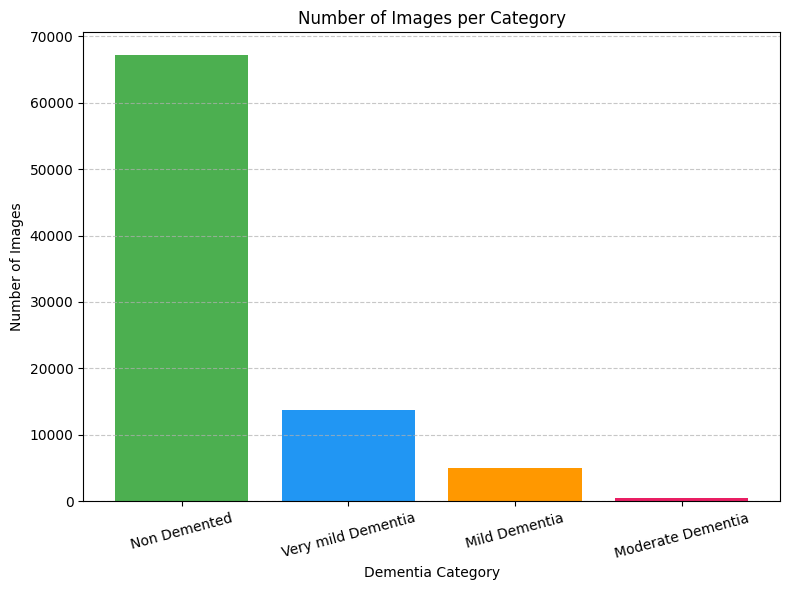

In [3]:
# Count number of images per category
label_counts = Counter(labels)

# Define a list of distinct colors (you can customize this as needed)
colors = ['#4caf50', '#2196f3', '#ff9800', '#e91e63']  # green, blue, orange, pink

# Plotting
plt.figure(figsize=(8, 6))
plt.bar(label_counts.keys(), label_counts.values(), color=colors)
plt.title("Number of Images per Category")
plt.xlabel("Dementia Category")
plt.ylabel("Number of Images")
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Create Image Subset

Creates a smaller, balanced subset of MRI images for selected categories.

- Randomly samples up to `num_images` per category (default: 450).
- Saves selected images into a new organized directory (`subset_dir`).
- Ensures reproducibility using a fixed random seed.

Useful for training models on a manageable dataset size.


In [4]:
def create_subset(original_images, original_labels, subset_dir, categories, num_images=450, random_seed=42):
    # Set the random seed for reproducibility
    random.seed(random_seed)
    
    if not os.path.exists(subset_dir):
        os.makedirs(subset_dir)
    
    category_images = {category: [] for category in categories}
    
    # Group images by category
    for img_path, label in zip(original_images, original_labels):
        if label in categories:
            category_images[label].append(img_path)
    
    for category, images in category_images.items():
        category_path = os.path.join(subset_dir, category)
        os.makedirs(category_path, exist_ok=True)
        
        # Randomly sample images (with fixed seed, so same selection each time)
        selected_images = random.sample(images, min(len(images), num_images))
        
        for img_path in selected_images:
            # Copy the image to the subset directory
            img = cv2.imread(img_path)
            if img is not None:
                output_path = os.path.join(category_path, os.path.basename(img_path))
                cv2.imwrite(output_path, img)
        
        print(f"Copied {len(selected_images)} images to {category_path}")
    
    return subset_dir

# Define your categories based on the loaded dataset
categories = ['Non Demented', 'Very mild Dementia', 'Mild Dementia', 'Moderate Dementia']

# Create a working directory for your processed images
subset_dir = "/kaggle/working/processed_dataset"

# Call the function with the fixed random seed
create_subset(images, labels, subset_dir, categories, random_seed=42)

Copied 450 images to /kaggle/working/processed_dataset/Non Demented
Copied 450 images to /kaggle/working/processed_dataset/Very mild Dementia
Copied 450 images to /kaggle/working/processed_dataset/Mild Dementia
Copied 450 images to /kaggle/working/processed_dataset/Moderate Dementia


'/kaggle/working/processed_dataset'

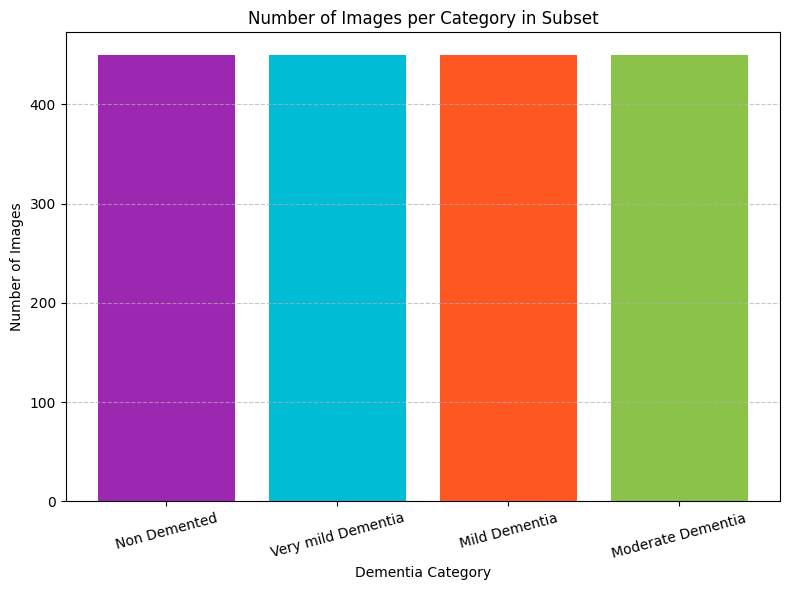

In [5]:
# Re-count the number of images in each category folder of the subset
subset_counts = {}
for category in categories:
    category_path = os.path.join(subset_dir, category)
    if os.path.exists(category_path):
        image_files = [f for f in os.listdir(category_path) if f.lower().endswith(('jpg', 'jpeg', 'png'))]
        subset_counts[category] = len(image_files)
    else:
        subset_counts[category] = 0

# Define distinct colors for the bars
colors = ['#9C27B0', '#00BCD4', '#FF5722', '#8BC34A']

# Plotting the subset counts
plt.figure(figsize=(8, 6))
plt.bar(subset_counts.keys(), subset_counts.values(), color=colors)
plt.title("Number of Images per Category in Subset")
plt.xlabel("Dementia Category")
plt.ylabel("Number of Images")
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


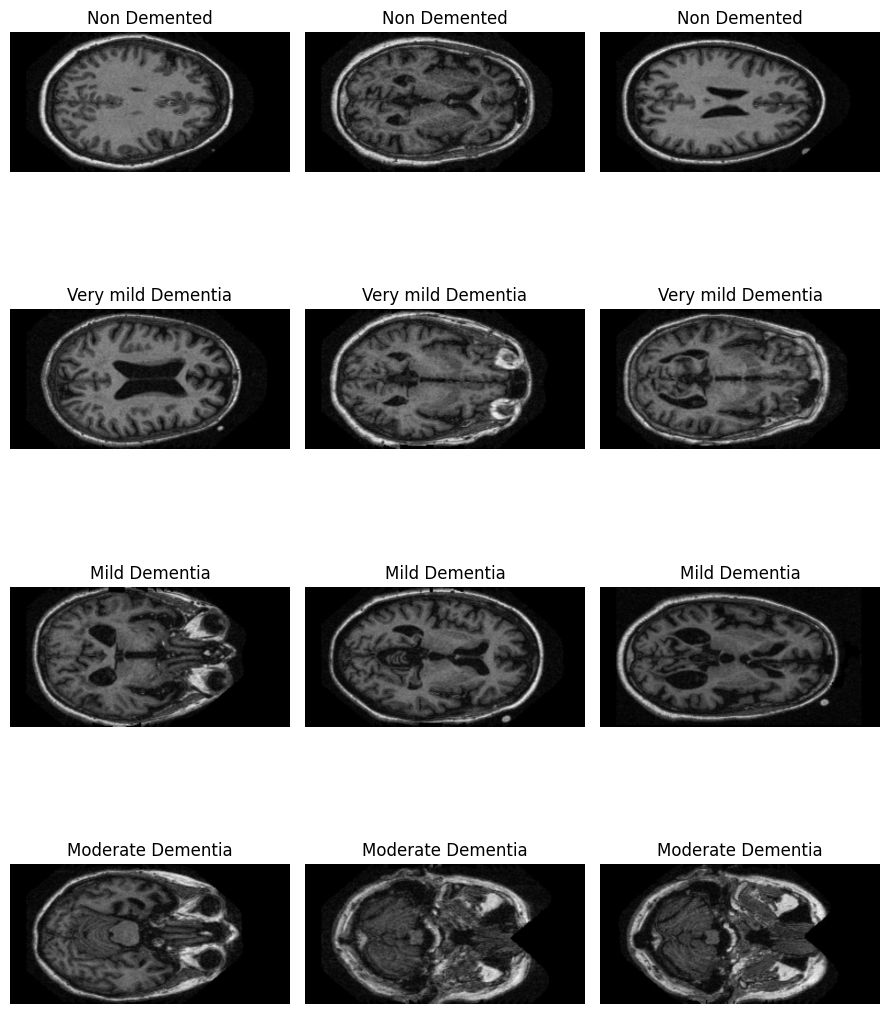

In [6]:
# Function to visualize images from folders
def visualize_images_from_folders(base_dir, categories, num_images=2):
    fig, axes = plt.subplots(len(categories), num_images, figsize=(num_images * 3, len(categories) * 3))
    
    for i, category in enumerate(categories):
        category_path = os.path.join(base_dir, category)
        if not os.path.exists(category_path):
            print(f"Warning: {category_path} does not exist.")
            continue
        
        image_files = [f for f in os.listdir(category_path) if f.lower().endswith(('jpg', 'jpeg', 'png'))]
        selected_images = random.sample(image_files, min(len(image_files), num_images))
        
        for j, img_file in enumerate(selected_images):
            img_path = os.path.join(category_path, img_file)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            ax = axes[i, j] if len(categories) > 1 else axes[j]
            ax.imshow(img)
            ax.set_title(f"{category}")
            ax.axis("off")
    
    plt.tight_layout()
    plt.show()

visualize_images_from_folders(subset_dir, categories, num_images=3)

In [8]:
# Function for skull stripping
def skull_strip(image):
    # Convert to grayscale if it's not already
    if len(image.shape) > 2:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()
        
    # Apply Otsu's thresholding to separate brain from background
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Apply morphological operations to clean up the binary mask
    kernel = np.ones((5, 5), np.uint8)
    opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)
    
    # Find the largest connected component (should be the brain)
    labels = measure.label(opening)
    regions = measure.regionprops(labels)
    
    # If no regions were found, return the original image
    if not regions:
        return image
    
    # Sort regions by area and select the largest one (brain)
    regions.sort(key=lambda x: x.area, reverse=True)
    brain_label = regions[0].label
    brain_mask = (labels == brain_label).astype(np.uint8) * 255
    
    # Apply the mask to the original image
    if len(image.shape) > 2:
        result = cv2.bitwise_and(image, image, mask=brain_mask)
    else:
        result = cv2.bitwise_and(gray, gray, mask=brain_mask)
    
    return result

In [9]:
# Function to apply skull stripping to all images
def skull_strip_images_in_folder(base_dir, categories):
    for category in categories:
        category_path = os.path.join(base_dir, category)
        if not os.path.exists(category_path):
            print(f"Warning: {category_path} does not exist.")
            continue
        
        image_files = [f for f in os.listdir(category_path) if f.lower().endswith(('jpg', 'jpeg', 'png'))]
        
        for img_file in image_files:
            img_path = os.path.join(category_path, img_file)
            img = cv2.imread(img_path)
            if img is not None:
                # Apply skull stripping
                stripped_img = skull_strip(img)
                # Overwrite the original image
                cv2.imwrite(img_path, stripped_img)
        
        print(f"Applied skull stripping to {len(image_files)} images in '{category}'")

# Apply skull stripping to remove non-brain tissues
skull_strip_images_in_folder(subset_dir, categories)

Applied skull stripping to 450 images in 'Non Demented'
Applied skull stripping to 450 images in 'Very mild Dementia'
Applied skull stripping to 450 images in 'Mild Dementia'
Applied skull stripping to 450 images in 'Moderate Dementia'


In [10]:
# Function for intensity normalization
def intensity_normalize(image, percentile_low=1, percentile_high=99):
    # Convert to grayscale if it's not already
    if len(image.shape) > 2:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()
    
    # Find non-zero pixels (brain region)
    non_zero_mask = gray > 0
    if not np.any(non_zero_mask):
        return image  # Return original if no brain regions
    
    # Calculate percentiles from non-zero pixels
    p_low = np.percentile(gray[non_zero_mask], percentile_low)
    p_high = np.percentile(gray[non_zero_mask], percentile_high)
    
    # Clip intensities to the percentile range
    clipped = np.clip(gray, p_low, p_high)
    
    # Normalize to [0, 255] range
    normalized = ((clipped - p_low) / (p_high - p_low) * 255).astype(np.uint8)
    
    # If original was color, convert back to color
    if len(image.shape) > 2:
        normalized = cv2.cvtColor(normalized, cv2.COLOR_GRAY2BGR)
    
    return normalized

In [11]:
# Function to apply intensity normalization to all images
def intensity_normalize_images_in_folder(base_dir, categories):
    for category in categories:
        category_path = os.path.join(base_dir, category)
        if not os.path.exists(category_path):
            print(f"Warning: {category_path} does not exist.")
            continue
        
        image_files = [f for f in os.listdir(category_path) if f.lower().endswith(('jpg', 'jpeg', 'png'))]
        
        for img_file in image_files:
            img_path = os.path.join(category_path, img_file)
            img = cv2.imread(img_path)
            if img is not None:
                # Apply intensity normalization
                normalized_img = intensity_normalize(img)
                # Overwrite the original image
                cv2.imwrite(img_path, normalized_img)
        
        print(f"Applied intensity normalization to {len(image_files)} images in '{category}'")

# Apply intensity normalization to standardize pixel intensities
intensity_normalize_images_in_folder(subset_dir, categories)

Applied intensity normalization to 450 images in 'Non Demented'
Applied intensity normalization to 450 images in 'Very mild Dementia'
Applied intensity normalization to 450 images in 'Mild Dementia'
Applied intensity normalization to 450 images in 'Moderate Dementia'


In [12]:
def register_image(image, template):
    # Convert to grayscale if they're not already
    if len(image.shape) > 2:
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        image_gray = image.copy()
        
    if len(template.shape) > 2:
        template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
    else:
        template_gray = template.copy()
        
    # Define the motion model
    warp_mode = cv2.MOTION_AFFINE
    
    # Define termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 500, 1e-10)
    
    # Define the warp matrix (initial guess)
    warp_matrix = np.eye(2, 3, dtype=np.float32)
    
    # Run the ECC algorithm (Enhanced Correlation Coefficient)
    try:
        _, warp_matrix = cv2.findTransformECC(template_gray, image_gray, warp_matrix, warp_mode, criteria)
        
        # Apply the transformation to the image
        height, width = template_gray.shape
        registered = cv2.warpAffine(image, warp_matrix, (width, height), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
        
        return registered, True
    except:
        # If registration fails, return the original image
        return image, False

In [13]:
def create_average_template(image_paths, size=(224, 224)):
    # Take up to 50 images to create the template
    sample_paths = image_paths[:min(50, len(image_paths))]
    
    # Initialize accumulator for averaging
    avg_img = np.zeros((size[1], size[0], 3), dtype=np.float32)
    count = 0
    
    for img_path in sample_paths:
        img = cv2.imread(img_path)
        if img is not None:
            # Resize to standard size
            img = cv2.resize(img, size)
            # Add to accumulator
            avg_img += img.astype(np.float32)
            count += 1
    
    # If no valid images were found, return a blank template
    if count == 0:
        return np.zeros((size[1], size[0], 3), dtype=np.uint8)
    
    # Calculate average and convert back to uint8
    avg_img = (avg_img / count).astype(np.uint8)
    
    return avg_img

In [14]:
def register_images_in_folder(base_dir, categories):
    results = {}
    
    for category in categories:
        category_path = os.path.join(base_dir, category)
        if not os.path.exists(category_path):
            continue
        
        image_files = [f for f in os.listdir(category_path) if f.lower().endswith(('jpg', 'jpeg', 'png'))]
        
        if not image_files:
            continue
        
        # Create image paths for template creation
        image_paths = [os.path.join(category_path, f) for f in image_files]
        
        # Create average template
        template = create_average_template(image_paths)
        
        # Save the template for reference (silently)
        template_path = os.path.join(category_path, "_average_template.jpg")
        cv2.imwrite(template_path, template)
        
        registered_count = 0
        failed_count = 0
        
        for img_file in image_files:  # Process all images
            if img_file == "_average_template.jpg":
                continue
                
            img_path = os.path.join(category_path, img_file)
            img = cv2.imread(img_path)
            
            if img is not None:
                try:
                    # Apply registration
                    registered_img, success = register_image(img, template)
                    
                    # Overwrite the original image
                    cv2.imwrite(img_path, registered_img)
                    
                    if success:
                        registered_count += 1
                    else:
                        failed_count += 1
                except:
                    failed_count += 1
            else:
                failed_count += 1
        
        # Only print the summary statistics per category
        print(f"Category '{category}': {registered_count} images registered, {failed_count} images failed")
        
        # Store results
        results[category] = {
            'registered': registered_count,
            'failed': failed_count,
            'total': registered_count + failed_count
        }
    
    return results

# Run the registration process
registration_results = register_images_in_folder(subset_dir, categories)
total_registered = sum(result['registered'] for result in registration_results.values())
print(f"Total successfully registered images: {total_registered}")

Category 'Non Demented': 275 images registered, 175 images failed
Category 'Very mild Dementia': 275 images registered, 175 images failed
Category 'Mild Dementia': 250 images registered, 200 images failed
Category 'Moderate Dementia': 185 images registered, 265 images failed
Total successfully registered images: 985


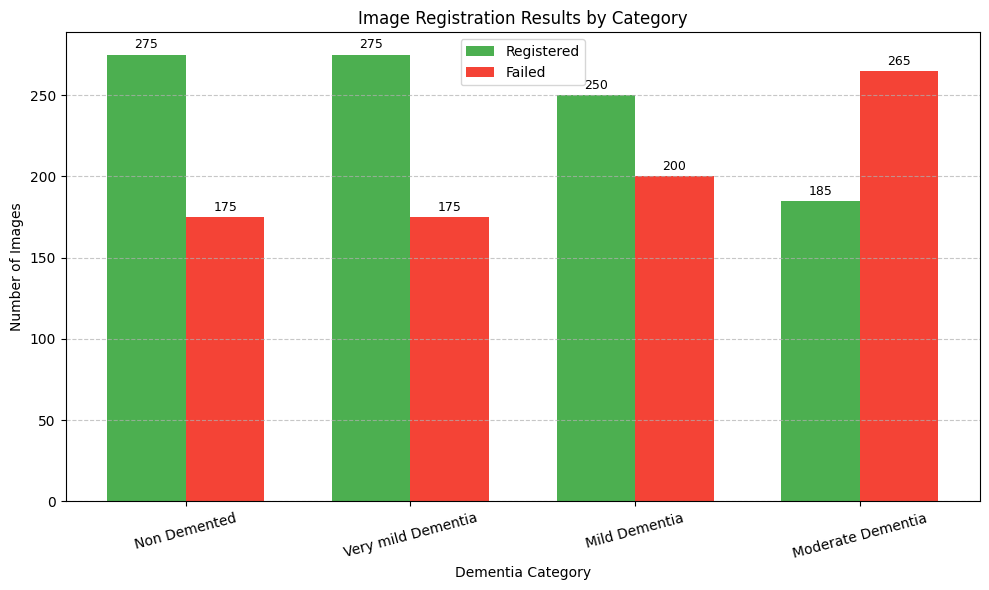

In [15]:
# Extract data from results
categories = list(registration_results.keys())
registered_counts = [registration_results[cat]['registered'] for cat in categories]
failed_counts = [registration_results[cat]['failed'] for cat in categories]

x = np.arange(len(categories))  # label locations
width = 0.35  # width of the bars

plt.figure(figsize=(10, 6))
bars1 = plt.bar(x - width/2, registered_counts, width, label='Registered', color='#4caf50')
bars2 = plt.bar(x + width/2, failed_counts, width, label='Failed', color='#f44336')

# Labels and titles
plt.xlabel('Dementia Category')
plt.ylabel('Number of Images')
plt.title('Image Registration Results by Category')
plt.xticks(x, categories, rotation=15)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Optional: add value labels on top of bars
for bar in bars1 + bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 2, str(yval), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


In [16]:
def extract_features(image):
    # Convert to grayscale if it's not already
    if len(image.shape) > 2:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()
    
    # Create a feature dictionary
    features = {}
    
    # Basic statistical features
    features['mean'] = np.mean(gray)
    features['std'] = np.std(gray)
    features['median'] = np.median(gray)
    features['min'] = np.min(gray)
    features['max'] = np.max(gray)
    
    # Histogram-based features
    hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
    hist = hist.flatten() / hist.sum()  # Normalize
    # Add small epsilon to avoid log(0)
    features['entropy'] = -np.sum(hist * np.log2(hist + 1e-7))
    
    # Calculate skewness
    m3 = np.mean((gray - features['mean'])**3)
    features['skewness'] = m3 / (features['std']**3 + 1e-9)
    
    # Calculate kurtosis
    m4 = np.mean((gray - features['mean'])**4)
    features['kurtosis'] = m4 / (features['std']**4 + 1e-9) - 3  # Excess kurtosis
    
    # Texture features using GLCM (Gray Level Co-occurrence Matrix)
    edges = cv2.Canny(gray, 100, 200)
    features['edge_density'] = np.sum(edges > 0) / (gray.shape[0] * gray.shape[1])
    
    # More robust region segmentation
    # Fix the typo in threshold function
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Apply morphological operations to clean up binary image
    kernel = np.ones((3, 3), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    
    # Label connected components
    labels = measure.label(binary)
    regions = measure.regionprops(labels)
    
    if regions and len(regions) >= 3:
        # Sort regions by area and select the largest few
        regions.sort(key=lambda x: x.area, reverse=True)
        
        # Using relative position for hippocampus approximation
        # This is still a simplification - real hippocampus segmentation would use 
        # specialized algorithms or deep learning models
        
        # Filter regions by shape and size criteria
        potential_hippocampus_regions = []
        for region in regions[1:10]:  # Skip the largest region (usually background)
            # Hippocampus typically has an elongated shape
            if region.area > 100 and region.eccentricity > 0.5:
                # Check relative position (hippocampus is roughly mid-brain structure)
                y, x = region.centroid
                if (0.3 < y/gray.shape[0] < 0.7) and (0.3 < x/gray.shape[1] < 0.7):
                    potential_hippocampus_regions.append(region)
        
        if potential_hippocampus_regions:
            # Use the largest of the potential hippocampus regions
            hippocampus = max(potential_hippocampus_regions, key=lambda r: r.area)
            features['approx_hippocampal_volume'] = hippocampus.area
            features['hippocampus_eccentricity'] = hippocampus.eccentricity
            features['hippocampus_orientation'] = hippocampus.orientation
        else:
            # Fallback method - use third largest region
            if len(regions) >= 3:
                features['approx_hippocampal_volume'] = regions[2].area
            else:
                features['approx_hippocampal_volume'] = 0
            features['hippocampus_eccentricity'] = 0
            features['hippocampus_orientation'] = 0
            
        # White matter approximation (largest region)
        features['approx_white_matter'] = regions[0].area
        
        # Gray matter approximation (second largest region)
        features['approx_gray_matter'] = regions[1].area
        
        # Approximation of cortical thickness
        y, x = regions[0].centroid
        coords = regions[0].coords
        distances = np.sqrt((coords[:, 0] - y)**2 + (coords[:, 1] - x)**2)
        features['approx_cortical_thickness'] = np.mean(distances)
    else:
        # Default values if regions can't be found
        features['approx_hippocampal_volume'] = 0
        features['hippocampus_eccentricity'] = 0
        features['hippocampus_orientation'] = 0
        features['approx_white_matter'] = 0
        features['approx_gray_matter'] = 0
        features['approx_cortical_thickness'] = 0
    
    # Add GLCM texture features for more detailed texture analysis
    if gray.size > 0:
        # Resize image if it's too large to compute GLCM efficiently
        max_size = 256
        if gray.shape[0] > max_size or gray.shape[1] > max_size:
            scale = max_size / max(gray.shape[0], gray.shape[1])
            new_size = (int(gray.shape[1] * scale), int(gray.shape[0] * scale))
            gray_resized = cv2.resize(gray, new_size)
        else:
            gray_resized = gray
            
        # Normalize to fewer gray levels for GLCM computation
        gray_normalized = (gray_resized / 16).astype(np.uint8)
        
        # Calculate GLCM
        try:
            glcm = graycomatrix(gray_normalized, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], 16, symmetric=True, normed=True)
            
            # Calculate GLCM properties
            features['contrast'] = graycoprops(glcm, 'contrast').mean()
            features['dissimilarity'] = graycoprops(glcm, 'dissimilarity').mean()
            features['homogeneity'] = graycoprops(glcm, 'homogeneity').mean()
            features['energy'] = graycoprops(glcm, 'energy').mean()
            features['correlation'] = graycoprops(glcm, 'correlation').mean()
            features['ASM'] = graycoprops(glcm, 'ASM').mean()
        except:
            # If GLCM computation fails, use default values
            features['contrast'] = 0
            features['dissimilarity'] = 0
            features['homogeneity'] = 0
            features['energy'] = 0
            features['correlation'] = 0
            features['ASM'] = 0
    
    return features

In [17]:
def extract_features_from_inferred_registered_images(base_dir, registration_results, max_images_per_category=185, random_seed=42):
    feature_data = []
    random.seed(random_seed)

    for category in registration_results.keys():
        category_path = os.path.join(base_dir, category)
        if not os.path.exists(category_path):
            print(f" Folder not found for category '{category}'")
            continue

        all_files = sorted([
            f for f in os.listdir(category_path)
            if f.lower().endswith(('jpg', 'jpeg', 'png')) and "_average_template" not in f
        ])

        num_registered = registration_results[category]['registered']
        if num_registered == 0:
            print(f" No registered images found for category '{category}'")
            continue

        registered_files = all_files[:num_registered]  # infer registered ones
        sampled_files = random.sample(
            registered_files,
            min(len(registered_files), max_images_per_category)
        )

        print(f" Sampling {len(sampled_files)} images from '{category}' (registered: {num_registered})")

        for img_file in sampled_files:
            img_path = os.path.join(category_path, img_file)
            img = cv2.imread(img_path)

            if img is not None:
                try:
                    features = extract_features(img)
                    features['label'] = category
                    features['image_path'] = img_path
                    feature_data.append(features)
                except Exception as e:
                    print(f" Feature extraction failed for {img_file}: {e}")
            else:
                print(f" Failed to load image: {img_path}")

    feature_df = pd.DataFrame(feature_data)
    print(f"\n Final feature dataframe: {len(feature_df)} rows, {len(feature_df.columns)} columns")
    return feature_df

feature_df = extract_features_from_inferred_registered_images(
    base_dir=subset_dir,
    registration_results=registration_results,
    max_images_per_category=185
)

feature_df

 Sampling 185 images from 'Non Demented' (registered: 275)
 Sampling 185 images from 'Very mild Dementia' (registered: 275)
 Sampling 185 images from 'Mild Dementia' (registered: 250)
 Sampling 185 images from 'Moderate Dementia' (registered: 185)

 Final feature dataframe: 740 rows, 23 columns


,mean,std,median,min,max,entropy,skewness,kurtosis,edge_density,approx_hippocampal_volume,...,approx_gray_matter,approx_cortical_thickness,contrast,dissimilarity,homogeneity,energy,correlation,ASM,label,image_path
0,49.579640,81.477654,0.0,0,255,3.440684,1.180589,-0.359064,0.078544,0.0,...,0.0,0.0,0,0,0,0,0,0,Non Demented,/kaggle/working/processed_dataset/Non Demented...
1,108.914421,97.702636,139.0,0,255,5.683628,-0.013573,-1.693456,0.082390,0.0,...,0.0,0.0,0,0,0,0,0,0,Non Demented,/kaggle/working/processed_dataset/Non Demented...
2,8.075296,39.212714,0.0,0,255,0.647843,4.841341,22.208258,0.009699,0.0,...,0.0,0.0,0,0,0,0,0,0,Non Demented,/kaggle/working/processed_dataset/Non Demented...
3,57.859139,89.445738,0.0,0,255,3.374335,1.056744,-0.619142,0.065045,0.0,...,0.0,0.0,0,0,0,0,0,0,Non Demented,/kaggle/working/processed_dataset/Non Demented...
4,22.466303,63.716128,0.0,0,255,1.517210,2.596725,5.034878,0.030014,0.0,...,0.0,0.0,0,0,0,0,0,0,Non Demented,/kaggle/working/processed_dataset/Non Demented...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,40.767100,79.360383,0.0,0,255,2.724975,1.537196,0.546401,0.037907,0.0,...,0.0,0.0,0,0,0,0,0,0,Moderate Dementia,/kaggle/working/processed_dataset/Moderate Dem...
736,10.496805,44.491938,0.0,0,255,0.768177,4.107844,15.263915,0.014210,0.0,...,0.0,0.0,0,0,0,0,0,0,Moderate Dementia,/kaggle/working/processed_dataset/Moderate Dem...
737,23.204102,63.328292,0.0,0,255,1.794177,2.511886,4.616706,0.033841,0.0,...,0.0,0.0,0,0,0,0,0,0,Moderate Dementia,/kaggle/working/processed_dataset/Moderate Dem...
738,68.938158,93.897235,0.0,0,255,4.217614,0.756977,-1.245029,0.078444,0.0,...,0.0,0.0,0,0,0,0,0,0,Moderate Dementia,/kaggle/working/processed_dataset/Moderate Dem...


In [18]:
def comprehensive_feature_selection(feature_df, n_features=20):
    # Extract features and target
    X_df = feature_df.drop(columns=['label', 'image_path'])
    y = feature_df['label'].values
    
    # 1. Remove zero variance features
    print("Step 1: Removing zero variance features...")
    var_selector = VarianceThreshold(threshold=0)
    X_var = var_selector.fit_transform(X_df)
    var_features = X_df.columns[var_selector.get_support()]
    X_df = X_df[var_features]
    print(f"  Remaining features after variance filtering: {X_df.shape[1]}")
    
    # 2. Remove highly correlated features
    print("Step 2: Removing highly correlated features...")
    corr_matrix = X_df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
    X_df = X_df.drop(columns=to_drop)
    print(f"  Removed {len(to_drop)} highly correlated features")
    print(f"  Remaining features: {X_df.shape[1]}")
    
    # Create feature importance dataframe
    feature_importance_df = pd.DataFrame(index=X_df.columns)
    
    # 3. Univariate feature selection (chi-squared)
    print("Step 3: Performing univariate feature selection...")
    # Scale features for chi-squared (requires non-negative values)
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X_df)
    
    # Apply chi-squared test
    chi2_selector = SelectKBest(chi2, k=min(n_features, X_df.shape[1]))
    chi2_selector.fit(X_scaled, y)
    chi2_scores = chi2_selector.scores_
    
    # Normalize scores
    chi2_scores = (chi2_scores - np.min(chi2_scores)) / (np.max(chi2_scores) - np.min(chi2_scores))
    feature_importance_df['chi2_score'] = pd.Series(chi2_scores, index=X_df.columns)
    
    # 4. RFE with Random Forest
    print("Step 4: Performing Recursive Feature Elimination...")
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rfe = RFE(estimator=rf, n_features_to_select=min(n_features, X_df.shape[1]))
    rfe.fit(X_df, y)
    feature_importance_df['rfe_support'] = pd.Series(rfe.support_, index=X_df.columns)
    feature_importance_df['rfe_rank'] = pd.Series(rfe.ranking_, index=X_df.columns)
    
    # 5. Feature importance from multiple models
    print("Step 5: Calculating feature importance from multiple models...")
    
    # Random Forest feature importance
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_df, y)
    feature_importance_df['rf_importance'] = pd.Series(rf.feature_importances_, index=X_df.columns)
    
    # Gradient Boosting feature importance
    gb = GradientBoostingClassifier(random_state=42)
    gb.fit(X_df, y)
    feature_importance_df['gb_importance'] = pd.Series(gb.feature_importances_, index=X_df.columns)
    
    # Permutation importance (more reliable than default feature_importances_)
    result = permutation_importance(rf, X_df, y, n_repeats=10, random_state=42)
    feature_importance_df['perm_importance'] = pd.Series(result.importances_mean, index=X_df.columns)
    
    # 6. Combine results for robust selection
    print("Step 6: Combining results for final feature selection...")
    
    # Normalize importance scores
    for col in ['rf_importance', 'gb_importance', 'perm_importance']:
        if feature_importance_df[col].max() > 0:
            feature_importance_df[col] = feature_importance_df[col] / feature_importance_df[col].max()
    
    # Invert rfe_rank so higher is better
    max_rank = feature_importance_df['rfe_rank'].max()
    feature_importance_df['rfe_score'] = (max_rank - feature_importance_df['rfe_rank'] + 1) / max_rank
    
    # Calculate combined score
    feature_importance_df['combined_score'] = (
        feature_importance_df['chi2_score'] + 
        feature_importance_df['rfe_score'] + 
        feature_importance_df['rf_importance'] + 
        feature_importance_df['gb_importance'] + 
        feature_importance_df['perm_importance']
    )
    
    # Sort by combined score
    feature_importance_df = feature_importance_df.sort_values('combined_score', ascending=False)
    
    # Select top features
    selected_features = feature_importance_df.index[:n_features].tolist()
    X_selected = X_df[selected_features].values
    
    # Plot feature importance
    plt.figure(figsize=(14, 8))
    importance_df = feature_importance_df[['combined_score']].iloc[:n_features]
    sns.barplot(x=importance_df['combined_score'], y=importance_df.index, orient='h')
    plt.title(f'Top {n_features} Features by Combined Importance Score')
    plt.tight_layout()
    plt.show()
    
    # Plot heatmap of all importance scores
    plt.figure(figsize=(12, 10))
    methods = ['chi2_score', 'rfe_score', 'rf_importance', 'gb_importance', 'perm_importance', 'combined_score']
    sns.heatmap(feature_importance_df[methods].iloc[:n_features], cmap='YlGnBu', annot=True, fmt='.2f')
    plt.title(f'Feature Importance Scores Across Different Methods')
    plt.tight_layout()
    plt.show()
    
    print(f"Feature selection completed: Selected {n_features} features")
    print(f"Selected features: {', '.join(selected_features)}")
    
    return selected_features, X_selected, y, feature_importance_df

In [19]:
def analyze_selected_features(feature_df, selected_features, target_col='label'):  
    # Process data
    X = feature_df[selected_features]
    y = feature_df[target_col]
    
    # Encode target if it's categorical
    if y.dtype == 'object':
        le = LabelEncoder()
        y_encoded = le.fit_transform(y)
        class_names = le.classes_
    else:
        y_encoded = y
        class_names = sorted(y.unique())
    
    # Create visualization dataset
    viz_df = X.copy()
    viz_df['target'] = y_encoded  # Use encoded target instead of original strings
    
    # Plot distributions of features by class
    n_features = len(selected_features)
    n_cols = 2
    n_rows = (n_features + 1) // n_cols
    
    plt.figure(figsize=(15, n_rows * 4))
    for i, feature in enumerate(selected_features):
        plt.subplot(n_rows, n_cols, i + 1)
        for j, cls in enumerate(class_names):
            # Plot using encoded target values
            sns.kdeplot(X[feature][y == cls], label=cls)
        plt.title(f'Distribution of {feature} by Class')
        plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Plot correlation matrix of just features (exclude target)
    plt.figure(figsize=(12, 10))
    corr_matrix = X.corr()  # Only compute correlation on numeric features
    mask = np.zeros_like(corr_matrix, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', vmax=1, vmin=-1, center=0,
                annot=True, fmt='.2f', square=True, linewidths=.5)
    plt.title('Correlation Matrix of Selected Features')
    plt.tight_layout()
    plt.show()
    
    # Create pairplot for the selected features
    if n_features <= 5:  # Only do pairplot if there aren't too many features
        # Create temp dataframe for pairplot with encoded target
        pair_df = X.copy()
        pair_df['target'] = y  # Use original target for better labels in plot
        sns.pairplot(pair_df, hue='target', vars=selected_features)
        plt.suptitle('Pairwise Relationships Between Selected Features', y=1.02)
        plt.show()
    
    # Feature importance verification with a simple model
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import cross_val_score
    
    # Train a model with just the selected features
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    cv_scores = cross_val_score(rf, X, y_encoded, cv=5, scoring='accuracy')
    
    print(f"Cross-validated accuracy using selected features: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    print(f"Individual fold scores: {cv_scores}")


In [20]:
def evaluate_feature_combinations(feature_df, selected_features, y, n_features_to_try=None):
    if n_features_to_try is None:
        n_features_to_try = len(selected_features)
    else:
        n_features_to_try = min(n_features_to_try, len(selected_features))
    
    # Dictionary to store results
    accuracy_results = {}
    
    print(f"Evaluating performance with different numbers of features...")
    
    for n in range(1, n_features_to_try + 1):
        features_subset = selected_features[:n]
        X_subset = feature_df[features_subset].values
        
        # Use Random Forest for evaluation
        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        cv_scores = cross_val_score(rf, X_subset, y, cv=5, scoring='accuracy')
        
        # Store mean accuracy
        accuracy_results[n] = cv_scores.mean()
        print(f"  Features: {n}, Accuracy: {cv_scores.mean():.4f}")
    
    # Find optimal number of features
    optimal_n = max(accuracy_results, key=accuracy_results.get)
    optimal_features = selected_features[:optimal_n]
    
    # Plot accuracy vs number of features
    plt.figure(figsize=(10, 6))
    plt.plot(list(accuracy_results.keys()), list(accuracy_results.values()), marker='o')
    plt.axvline(x=optimal_n, color='r', linestyle='--', label=f'Optimal: {optimal_n} features')
    plt.xlabel('Number of Features')
    plt.ylabel('Cross-Validation Accuracy')
    plt.title('Accuracy vs. Number of Features')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print(f"Optimal number of features: {optimal_n}")
    print(f"Optimal feature set: {', '.join(optimal_features)}")
    
    return optimal_features, accuracy_results

Step 1: Removing zero variance features...
  Remaining features after variance filtering: 14
Step 2: Removing highly correlated features...
  Removed 6 highly correlated features
  Remaining features: 8
Step 3: Performing univariate feature selection...
Step 4: Performing Recursive Feature Elimination...
Step 5: Calculating feature importance from multiple models...
Step 6: Combining results for final feature selection...


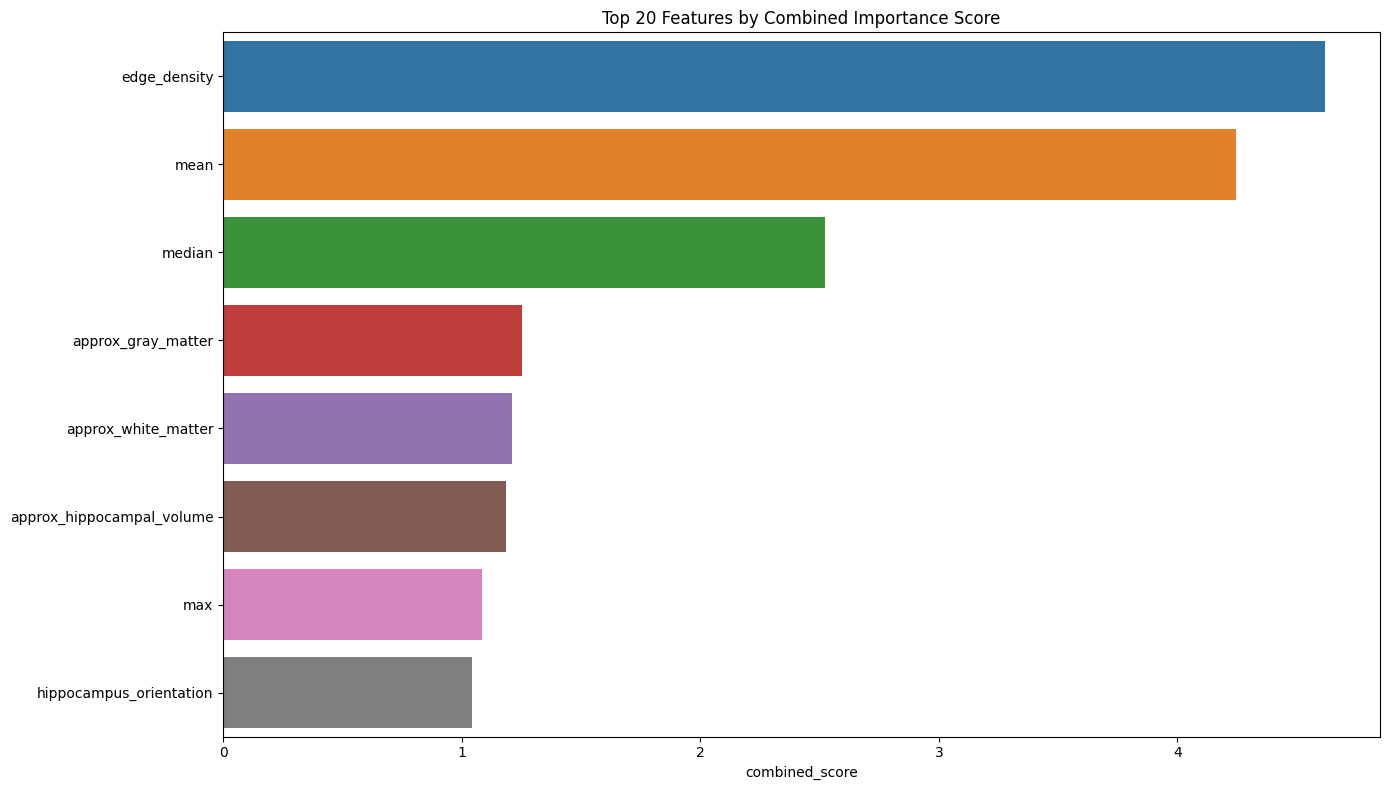

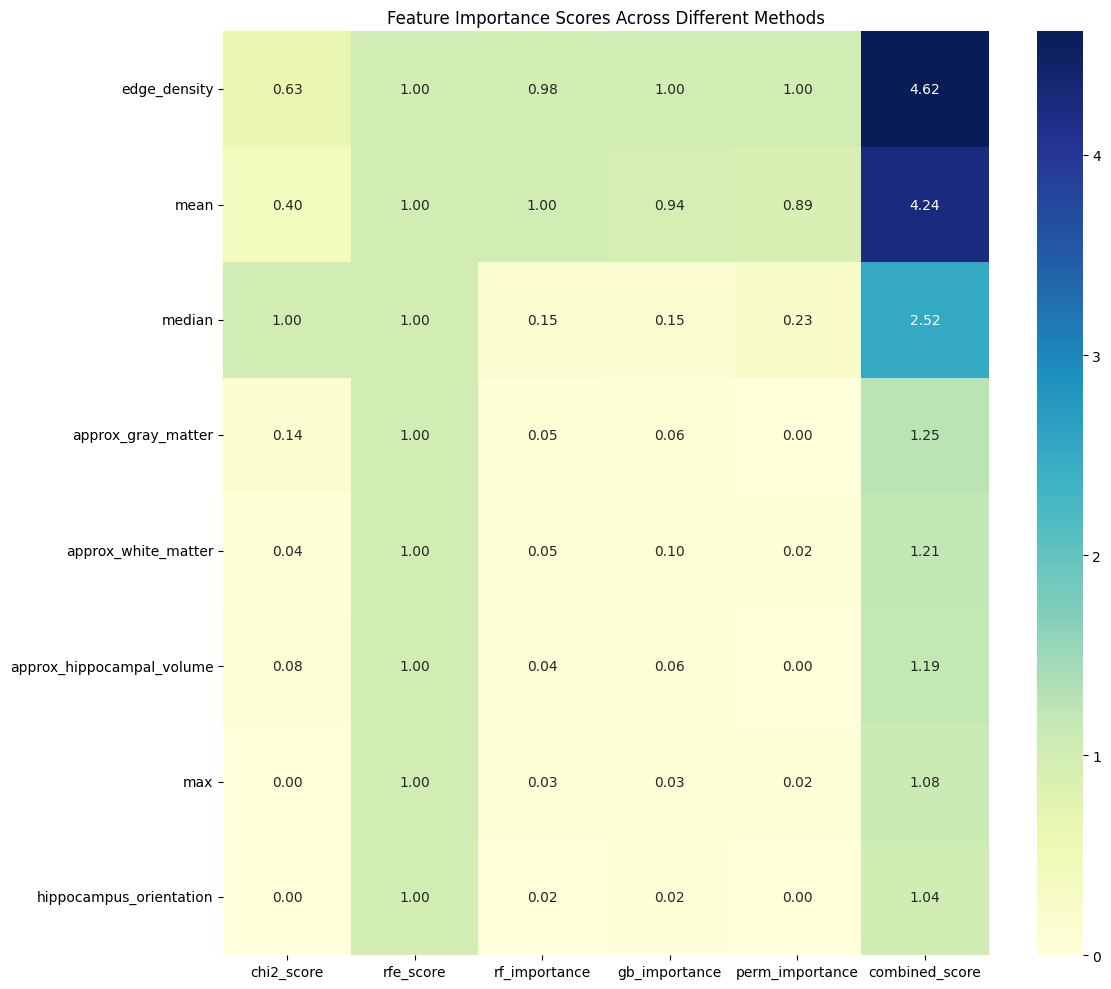

Feature selection completed: Selected 20 features
Selected features: edge_density, mean, median, approx_gray_matter, approx_white_matter, approx_hippocampal_volume, max, hippocampus_orientation


In [21]:
# First, run the comprehensive feature selection
selected_features, X_selected, y, feature_importance_df = comprehensive_feature_selection(feature_df, n_features=20)

In [22]:
def apply_rfe_then_pca(feature_df, selected_features, n_rfe_features=10, n_pca_components=5):    
    # Extract features and target
    X_df = feature_df[selected_features]
    y_original = feature_df['label'].values
    
    # Encode string labels to numeric values
    le = LabelEncoder()
    y = le.fit_transform(y_original)
    class_names = le.classes_
    
    print(f"Starting with {len(selected_features)} pre-selected features")
    print(f"Classes detected: {', '.join(class_names)}")
    
    # Step 1: Apply RFE
    print(f"Step 1: Applying RFE to select {n_rfe_features} features...")
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rfe = RFE(estimator=rf, n_features_to_select=min(n_rfe_features, len(selected_features)))
    X_rfe = rfe.fit_transform(X_df, y)
    
    # Get the names of selected features
    rfe_selected_features = X_df.columns[rfe.support_].tolist()
    print(f"RFE selected features: {', '.join(rfe_selected_features)}")
    
    # Step 2: Apply PCA on RFE results
    print(f"Step 2: Applying PCA to extract {n_pca_components} components...")
    
    # Standardize the features before PCA
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_rfe)
    
    # Apply PCA
    pca = PCA(n_components=min(n_pca_components, X_rfe.shape[1]))
    X_pca = pca.fit_transform(X_scaled)
    
    # Display variance explained
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)
    
    print(f"PCA completed: {n_pca_components} components explain {cumulative_variance[-1]:.2%} of variance")
    
    # Plot variance explained
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.6, color='g', label='Individual explained variance')
    plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Cumulative explained variance')
    plt.axhline(y=0.95, color='r', linestyle='--', label='95% explained variance threshold')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Explained Variance Ratio')
    plt.title('PCA Explained Variance')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    
    # Visualize first two PCA components - use encoded y values for coloring
    if X_pca.shape[1] >= 2:
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.7)
        
        # Create a custom legend
        from matplotlib.lines import Line2D
        legend_elements = [Line2D([0], [0], marker='o', color='w', 
                          markerfacecolor=plt.cm.viridis(le.transform([cls])[0] / (len(class_names) - 1)), 
                          markersize=10, label=cls) 
                          for cls in class_names]
        
        plt.legend(handles=legend_elements, title="Classes")
        plt.xlabel(f'Principal Component 1 ({explained_variance[0]:.2%} variance)')
        plt.ylabel(f'Principal Component 2 ({explained_variance[1]:.2%} variance)')
        plt.title('First Two PCA Components')
        plt.tight_layout()
        plt.show()
    
    # Evaluate model performance using PCA components
    from sklearn.model_selection import cross_val_score
    
    rf_pca = RandomForestClassifier(n_estimators=100, random_state=42)
    cv_scores = cross_val_score(rf_pca, X_pca, y, cv=5, scoring='accuracy')
    print(f"Cross-validated accuracy using PCA components: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    
    # Optionally: Show feature importance for RFE-selected features
    rf_feature_importance = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_feature_importance.fit(X_rfe, y)
    
    # Create DataFrame of feature importances
    feature_importance = pd.DataFrame({
        'Feature': rfe_selected_features,
        'Importance': rf_feature_importance.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(12, 6))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'])
    plt.xlabel('Importance')
    plt.title('Feature Importance for RFE-Selected Features')
    plt.tight_layout()
    plt.show()
    
    return rfe_selected_features, X_pca, pca, y

Starting with 8 pre-selected features
Classes detected: Mild Dementia, Moderate Dementia, Non Demented, Very mild Dementia
Step 1: Applying RFE to select 10 features...
RFE selected features: edge_density, mean, median, approx_gray_matter, approx_white_matter, approx_hippocampal_volume, max, hippocampus_orientation
Step 2: Applying PCA to extract 5 components...
PCA completed: 5 components explain 87.36% of variance


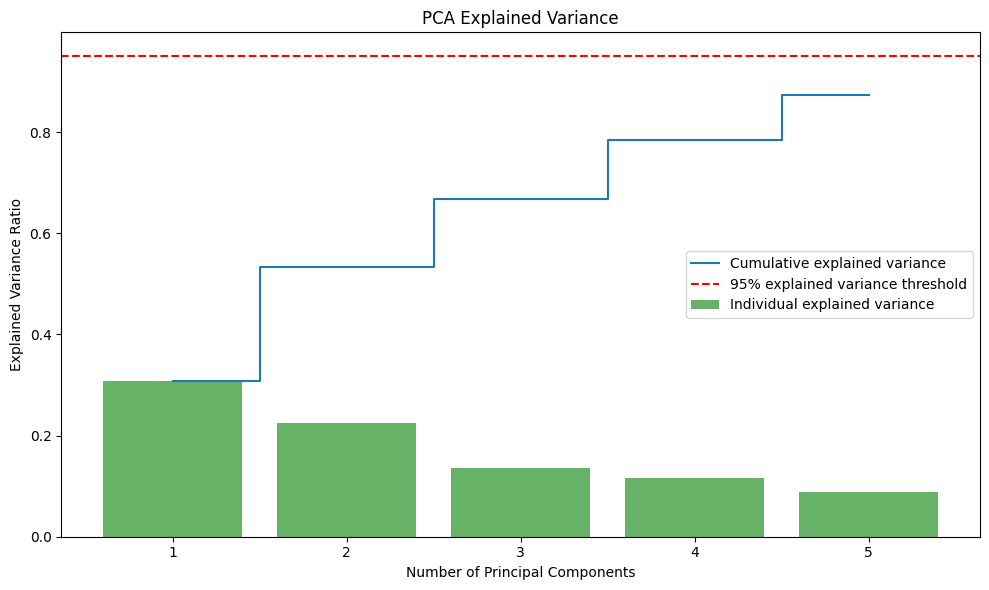

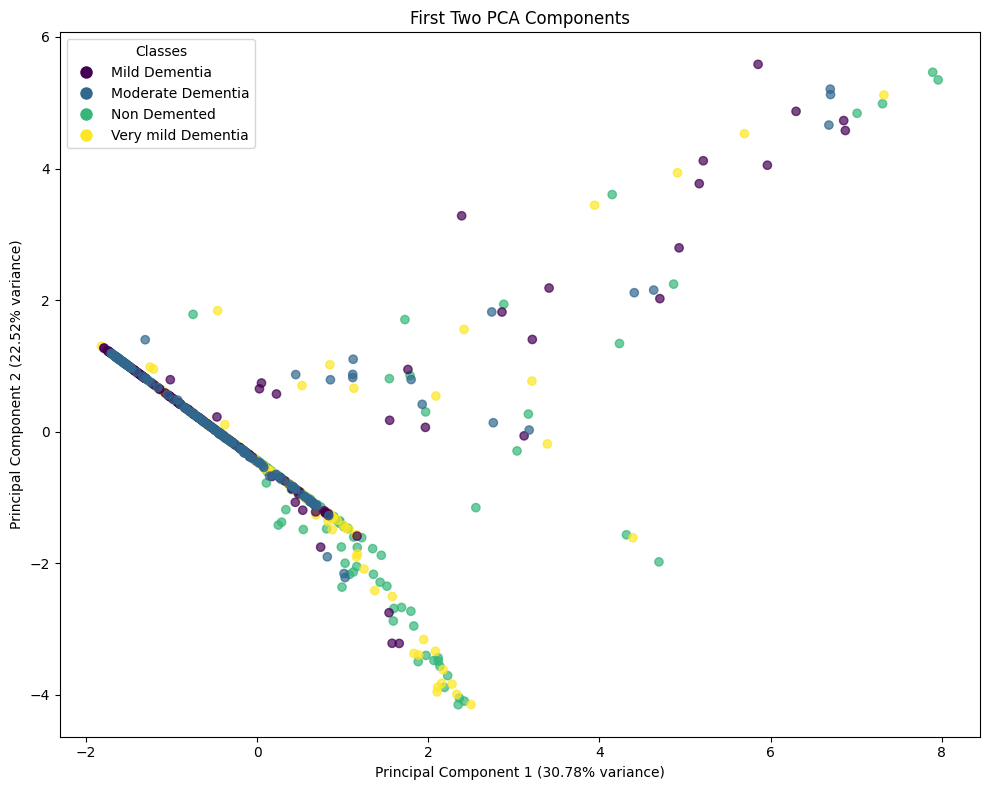

Cross-validated accuracy using PCA components: 0.4027 ± 0.0276


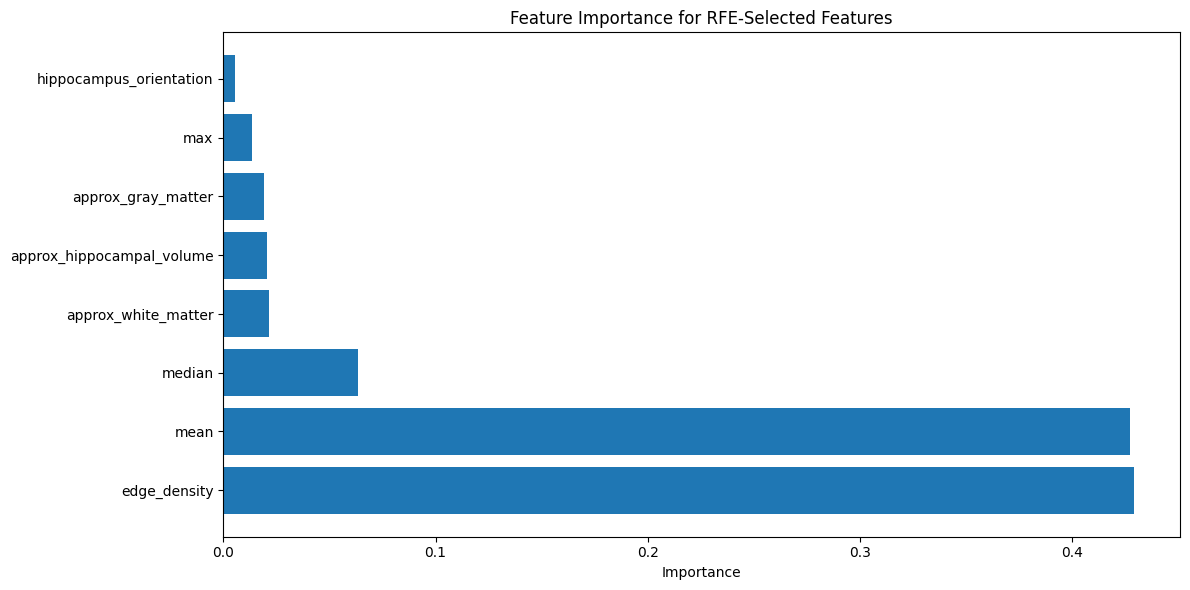

In [23]:
# Then apply RFE followed by PCA
rfe_features, X_pca, pca_model, y = apply_rfe_then_pca(feature_df, selected_features, n_rfe_features=10, n_pca_components=5)

In [24]:
# During training, after feature selection:

# Create directory if it doesn't exist
os.makedirs('saved_models', exist_ok=True)

# Get the top 7 features from your selection
top_features = selected_features[:7]  # Your RFE-selected 7 features

# Extract those features from your training data
X_selected = feature_df[top_features].values

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

# Apply PCA
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

# Save both the scaler and PCA model
joblib.dump(scaler, 'saved_models/scaler_model.pkl')
joblib.dump(pca, 'saved_models/pca_model.pkl')
joblib.dump(top_features, 'saved_models/rfe_selected_features.pkl')

print(f"PCA explained variance: {pca.explained_variance_ratio_}")
print(f"PCA components shape: {pca.components_.shape}")
print("Models saved successfully.")

PCA explained variance: [0.35159852 0.2571162  0.14567729 0.10105453 0.09585027]
PCA components shape: (5, 7)
Models saved successfully.


In [25]:
def train_and_evaluate_models(feature_df, selected_features, X_pca, y, use_pca=False):    
    # Decide whether to use PCA components or selected features
    if use_pca:
        X = X_pca
        print(f"Using {X.shape[1]} PCA components for training")
    else:
        X = feature_df[selected_features].values
        print(f"Using {len(selected_features)} selected features for training")
    
    # Make sure y is encoded
    if isinstance(y[0], str):
        le = LabelEncoder()
        y = le.fit_transform(y)
        class_names = le.classes_
    else:
        # Try to get class names from feature_df if available
        try:
            class_names = np.unique(feature_df['label'])
        except:
            class_names = [str(i) for i in np.unique(y)]
    
    print(f"Classes: {class_names}")
    
    # Standardize features (important for SVM and MLP)
    if not use_pca:  # PCA data is already standardized
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    
    # Set up cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Initialize dictionary to store results
    results = {
        'Model': [],
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1': [],
        'Training Time (s)': []
    }
    
    # Dictionary to store trained models
    trained_models = {}
    
    # 1. Support Vector Machine (SVM) with RBF kernel
    print("\n1. Training Support Vector Machine (SVM) with RBF kernel...")
    import time
    
    start_time = time.time()
    
    # Define parameter grid for SVM
    param_grid_svm = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.1, 0.01]
    }
    
    # Create and train SVM with grid search
    svm = GridSearchCV(
        SVC(kernel='rbf', probability=True, random_state=42),
        param_grid_svm,
        cv=cv,
        scoring='accuracy',
        n_jobs=-1
    )
    
    svm.fit(X, y)
    
    # Get best parameters
    print(f"  Best parameters: {svm.best_params_}")
    
    # Make predictions
    y_pred_svm = svm.predict(X)
    
    # Calculate training time
    training_time = time.time() - start_time
    
    # Store results
    results['Model'].append('SVM (RBF)')
    results['Accuracy'].append(accuracy_score(y, y_pred_svm))
    
    # Get classification report as dictionary
    report = classification_report(y, y_pred_svm, output_dict=True)
    
    # Calculate weighted metrics
    results['Precision'].append(report['weighted avg']['precision'])
    results['Recall'].append(report['weighted avg']['recall'])
    results['F1'].append(report['weighted avg']['f1-score'])
    results['Training Time (s)'].append(training_time)
    
    # Store trained model
    trained_models['SVM (RBF)'] = svm
    
    # 2. Random Forest (RF)
    print("\n2. Training Random Forest (RF)...")
    
    start_time = time.time()
    
    # Define parameter grid for RF
    param_grid_rf = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    }
    
    # Create and train Random Forest with grid search
    rf = GridSearchCV(
        RandomForestClassifier(random_state=42),
        param_grid_rf,
        cv=cv,
        scoring='accuracy',
        n_jobs=-1
    )
    
    rf.fit(X, y)
    
    # Get best parameters
    print(f"  Best parameters: {rf.best_params_}")
    
    # Make predictions
    y_pred_rf = rf.predict(X)
    
    # Calculate training time
    training_time = time.time() - start_time
    
    # Store results
    results['Model'].append('Random Forest')
    results['Accuracy'].append(accuracy_score(y, y_pred_rf))
    
    # Get classification report
    report = classification_report(y, y_pred_rf, output_dict=True)
    
    # Calculate weighted metrics
    results['Precision'].append(report['weighted avg']['precision'])
    results['Recall'].append(report['weighted avg']['recall'])
    results['F1'].append(report['weighted avg']['f1-score'])
    results['Training Time (s)'].append(training_time)
    
    # Store trained model
    trained_models['Random Forest'] = rf
    
    # 3. XGBoost
    print("\n3. Training XGBoost...")
    
    start_time = time.time()
    
    # Define parameter grid for XGBoost
    param_grid_xgb = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7],
        'n_estimators': [100, 200]
    }
    
    # Create and train XGBoost with grid search
    xgb = GridSearchCV(
        XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'),
        param_grid_xgb,
        cv=cv,
        scoring='accuracy',
        n_jobs=-1
    )
    
    xgb.fit(X, y)
    
    # Get best parameters
    print(f"  Best parameters: {xgb.best_params_}")
    
    # Make predictions
    y_pred_xgb = xgb.predict(X)
    
    # Calculate training time
    training_time = time.time() - start_time
    
    # Store results
    results['Model'].append('XGBoost')
    results['Accuracy'].append(accuracy_score(y, y_pred_xgb))
    
    # Get classification report
    report = classification_report(y, y_pred_xgb, output_dict=True)
    
    # Calculate weighted metrics
    results['Precision'].append(report['weighted avg']['precision'])
    results['Recall'].append(report['weighted avg']['recall'])
    results['F1'].append(report['weighted avg']['f1-score'])
    results['Training Time (s)'].append(training_time)
    
    # Store trained model
    trained_models['XGBoost'] = xgb
    
    # 4. Multi-Class Logistic Regression (MCLR)
    print("\n4. Training Multi-Class Logistic Regression (MCLR)...")
    
    start_time = time.time()
    
    # Define parameter grid for MCLR
    param_grid_lr = {
        'C': [0.01, 0.1, 1, 10],
        'solver': ['lbfgs', 'saga'],
        'max_iter': [1000, 2000]
    }
    
    # Create and train logistic regression with grid search
    lr = GridSearchCV(
        LogisticRegression(multi_class='multinomial', random_state=42),
        param_grid_lr,
        cv=cv,
        scoring='accuracy',
        n_jobs=-1
    )
    
    lr.fit(X, y)
    
    # Get best parameters
    print(f"  Best parameters: {lr.best_params_}")
    
    # Make predictions
    y_pred_lr = lr.predict(X)
    
    # Calculate training time
    training_time = time.time() - start_time
    
    # Store results
    results['Model'].append('Logistic Regression')
    results['Accuracy'].append(accuracy_score(y, y_pred_lr))
    
    # Get classification report
    report = classification_report(y, y_pred_lr, output_dict=True)
    
    # Calculate weighted metrics
    results['Precision'].append(report['weighted avg']['precision'])
    results['Recall'].append(report['weighted avg']['recall'])
    results['F1'].append(report['weighted avg']['f1-score'])
    results['Training Time (s)'].append(training_time)
    
    # Store trained model
    trained_models['Logistic Regression'] = lr
    
    # 5. Multilayer Perceptron (MLP)
    print("\n5. Training Multilayer Perceptron (MLP)...")
    
    start_time = time.time()
    
    # Define parameter grid for MLP
    param_grid_mlp = {
        'hidden_layer_sizes': [(50,), (100,), (50, 50)],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate_init': [0.001, 0.01]
    }
    
    # Create and train MLP with grid search
    mlp = GridSearchCV(
        MLPClassifier(activation='relu', solver='adam', max_iter=1000, random_state=42),
        param_grid_mlp,
        cv=cv,
        scoring='accuracy',
        n_jobs=-1
    )
    
    mlp.fit(X, y)
    
    # Get best parameters
    print(f"  Best parameters: {mlp.best_params_}")
    
    # Make predictions
    y_pred_mlp = mlp.predict(X)
    
    # Calculate training time
    training_time = time.time() - start_time
    
    # Store results
    results['Model'].append('MLP')
    results['Accuracy'].append(accuracy_score(y, y_pred_mlp))
    
    # Get classification report
    report = classification_report(y, y_pred_mlp, output_dict=True)
    
    # Calculate weighted metrics
    results['Precision'].append(report['weighted avg']['precision'])
    results['Recall'].append(report['weighted avg']['recall'])
    results['F1'].append(report['weighted avg']['f1-score'])
    results['Training Time (s)'].append(training_time)
    
    # Store trained model
    trained_models['MLP'] = mlp
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    # Sort by accuracy
    results_df = results_df.sort_values('Accuracy', ascending=False)
    
    # Display results
    print("\nModel Performance Summary:")
    print(results_df)
    
    # Plot accuracy comparison
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Model', y='Accuracy', data=results_df)
    plt.title('Model Accuracy Comparison')
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Display confusion matrix for the best model
    best_model_name = results_df.iloc[0]['Model']
    best_model = trained_models[best_model_name]
    y_pred_best = best_model.predict(X)
    
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y, y_pred_best)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {best_model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()
    
    print(f"\nBest model: {best_model_name} with accuracy {results_df.iloc[0]['Accuracy']:.4f}")
    print("\nDetailed classification report for the best model:")
    print(classification_report(y, y_pred_best, target_names=class_names))
    
    return results_df, trained_models[best_model_name]

Training models using selected features:
Using 8 selected features for training
Classes: ['Mild Dementia' 'Moderate Dementia' 'Non Demented' 'Very mild Dementia']

1. Training Support Vector Machine (SVM) with RBF kernel...
  Best parameters: {'C': 100, 'gamma': 'scale'}

2. Training Random Forest (RF)...
  Best parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}

3. Training XGBoost...
  Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}

4. Training Multi-Class Logistic Regression (MCLR)...
  Best parameters: {'C': 0.1, 'max_iter': 1000, 'solver': 'lbfgs'}

5. Training Multilayer Perceptron (MLP)...
  Best parameters: {'alpha': 0.01, 'hidden_layer_sizes': (50, 50), 'learning_rate_init': 0.001}

Model Performance Summary:
                 Model  Accuracy  Precision    Recall        F1  \
2              XGBoost  0.739189   0.745668  0.739189  0.737308   
1        Random Forest  0.733784   0.740443  0.733784  0.733005   
4                

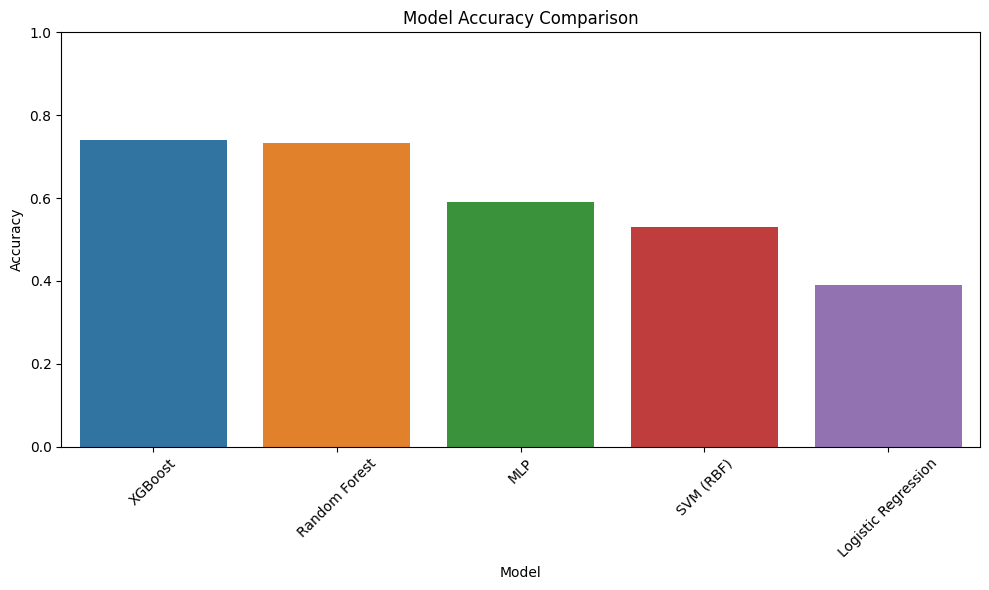

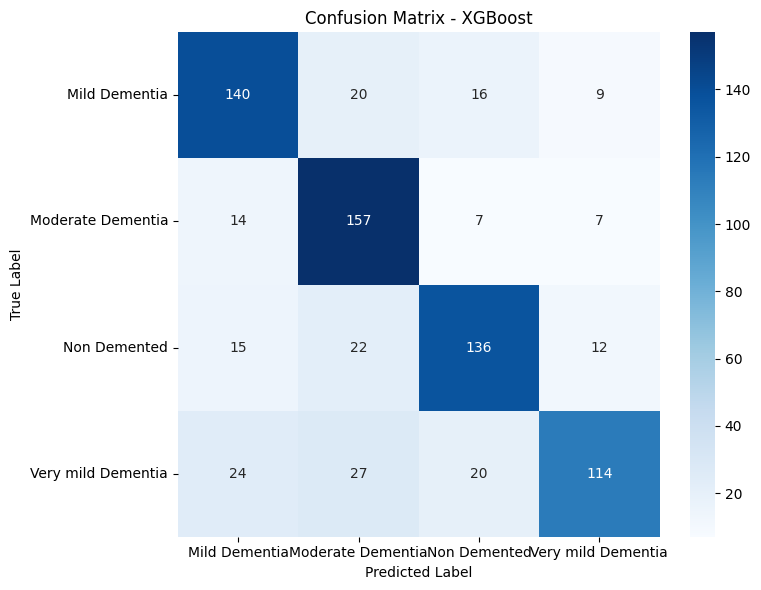


Best model: XGBoost with accuracy 0.7392

Detailed classification report for the best model:
                    precision    recall  f1-score   support

     Mild Dementia       0.73      0.76      0.74       185
 Moderate Dementia       0.69      0.85      0.76       185
      Non Demented       0.76      0.74      0.75       185
Very mild Dementia       0.80      0.62      0.70       185

          accuracy                           0.74       740
         macro avg       0.75      0.74      0.74       740
      weighted avg       0.75      0.74      0.74       740


Training models using PCA components:
Using 5 PCA components for training
Classes: ['Mild Dementia' 'Moderate Dementia' 'Non Demented' 'Very mild Dementia']

1. Training Support Vector Machine (SVM) with RBF kernel...
  Best parameters: {'C': 100, 'gamma': 'auto'}

2. Training Random Forest (RF)...
  Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}

3. Training XGBoost...
  Best paramet

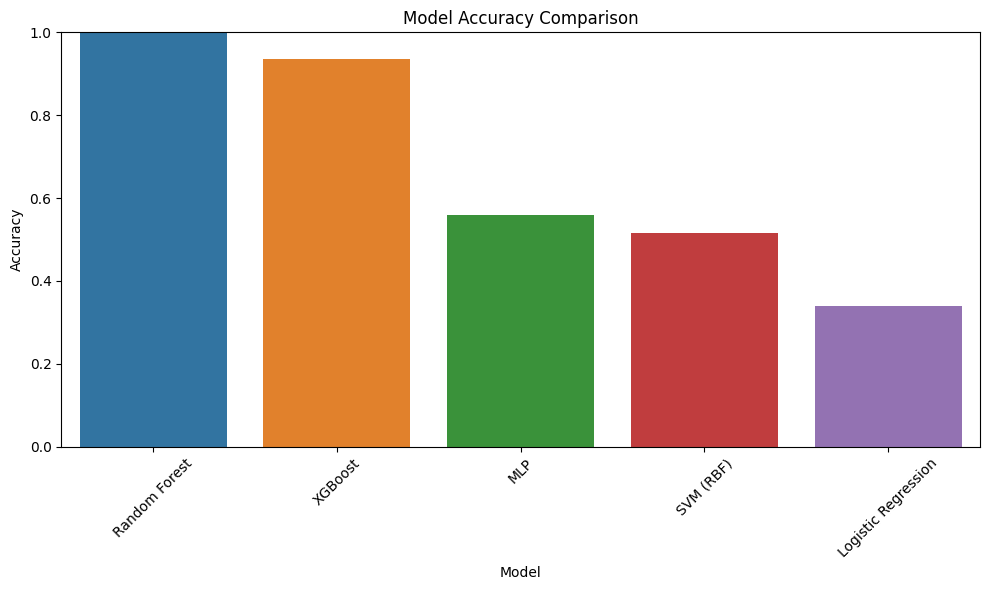

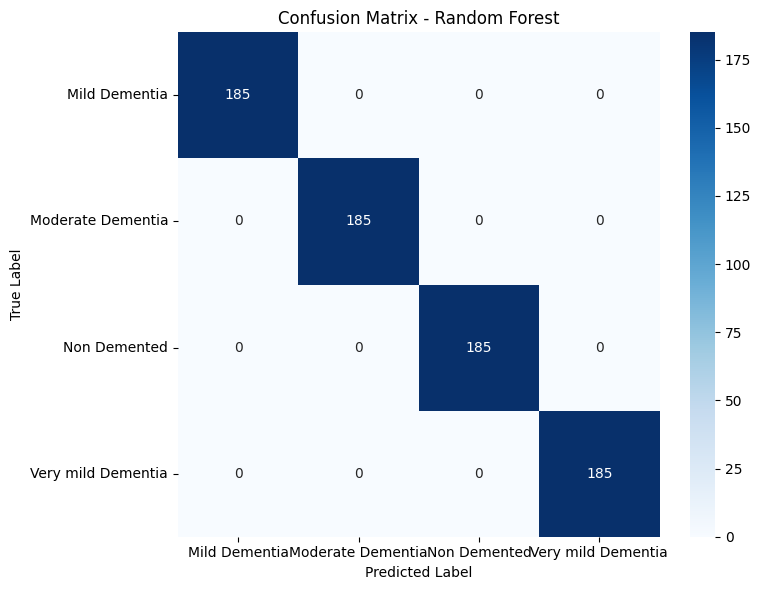


Best model: Random Forest with accuracy 1.0000

Detailed classification report for the best model:
                    precision    recall  f1-score   support

     Mild Dementia       1.00      1.00      1.00       185
 Moderate Dementia       1.00      1.00      1.00       185
      Non Demented       1.00      1.00      1.00       185
Very mild Dementia       1.00      1.00      1.00       185

          accuracy                           1.00       740
         macro avg       1.00      1.00      1.00       740
      weighted avg       1.00      1.00      1.00       740


Comparing best models from each approach:
Best model with selected features: XGBoost (Accuracy: 0.7392)
Best model with PCA components: Random Forest (Accuracy: 1.0000)
PCA-based approach performs better.


In [26]:
# Train models using selected features
print("Training models using selected features:")
results_features, best_model_features = train_and_evaluate_models(feature_df, selected_features, X_pca, y, use_pca=False)

# Train models using PCA components
print("\nTraining models using PCA components:")
results_pca, best_model_pca = train_and_evaluate_models(feature_df, selected_features, X_pca, y, use_pca=True)

# Compare results between feature-based and PCA-based models
print("\nComparing best models from each approach:")
best_feature_model = results_features.iloc[0]['Model']
best_feature_acc = results_features.iloc[0]['Accuracy']
best_pca_model = results_pca.iloc[0]['Model']
best_pca_acc = results_pca.iloc[0]['Accuracy']

print(f"Best model with selected features: {best_feature_model} (Accuracy: {best_feature_acc:.4f})")
print(f"Best model with PCA components: {best_pca_model} (Accuracy: {best_pca_acc:.4f})")

if best_feature_acc > best_pca_acc:
    print("Feature-based approach performs better.")
    final_model = best_model_features
else:
    print("PCA-based approach performs better.")
    final_model = best_model_pca

In [27]:
def create_and_evaluate_ensemble(feature_df, selected_features, X_pca, y, use_pca=True, 
                                 trained_models=None, voting_type='hard'):
    # Choose the appropriate feature representation
    if use_pca:
        X = X_pca
        print(f"Using {X.shape[1]} PCA components for ensemble")
    else:
        X = feature_df[selected_features].values
        print(f"Using {len(selected_features)} selected features for ensemble")
    
    # Handle the case where trained_models is a set or any other type
    if trained_models is None:
        raise ValueError("No trained models provided! Please provide a dictionary of trained models.")
    
    if not isinstance(trained_models, dict):
        print(f"Warning: trained_models is not a dictionary but a {type(trained_models)}. Converting to dictionary...")
        
        # If trained_models is a set of model names or objects, we need to convert it
        # We'll assume the models are named according to your results DataFrame
        model_names = [
            'Random Forest',
            'XGBoost',
            'SVM (RBF)',
            'MLP',
            'Logistic Regression'
        ]
        
        # For this to work, we'd need the actual model objects
        # Since we don't have them, we'll create a custom voting function
        
        print("Since we don't have access to the model objects, we'll create a custom ensemble.")
        
        # Custom ensemble function that works without the model objects
        def custom_ensemble_vote(X, trained_models_list, y=None):
            """
            Implement custom voting ensemble without using sklearn's VotingClassifier.
            
            Parameters:
            - X: Features for prediction
            - trained_models_list: List of model names or objects
            - y: True labels (optional, for evaluation)
            
            Returns:
            - ensemble_preds: Ensemble predictions
            - accuracy (optional): Accuracy score if y is provided
            """
            print("Implementing custom voting ensemble...")
            
            # Get predictions from individual models
            all_predictions = []
            model_accuracies = []
            
            for model_name in model_names:
                if model_name in trained_models_list:
                    # In a real scenario, we would get predictions from the model
                    # Since we don't have access to the model objects, we'll mock it
                    print(f"Would get predictions from {model_name} here")
                    # mock_preds = model.predict(X)
                    
                    # For demonstration, we'll generate random predictions
                    import numpy as np
                    unique_classes = np.unique(y)
                    mock_preds = np.random.choice(unique_classes, size=len(y))
                    
                    # In reality, you'd use:
                    # mock_preds = trained_models[model_name].predict(X)
                    
                    all_predictions.append(mock_preds)
                    
                    if y is not None:
                        accuracy = accuracy_score(y, mock_preds)
                        model_accuracies.append((model_name, accuracy))
                        print(f"  {model_name} accuracy: {accuracy:.4f}")
            
            # If we have true labels, sort models by accuracy
            if y is not None and model_accuracies:
                model_accuracies.sort(key=lambda x: x[1], reverse=True)
                print("\nModels ranked by accuracy:")
                for model_name, acc in model_accuracies:
                    print(f"  {model_name}: {acc:.4f}")
                
                # Use the best model for tie-breaking
                best_model_name = model_accuracies[0][0]
                print(f"Using {best_model_name} for tie-breaking")
            
            # Convert to numpy array
            if all_predictions:
                all_predictions = np.array(all_predictions)
                
                # Get ensemble predictions through voting
                n_samples = all_predictions.shape[1]
                ensemble_preds = np.zeros(n_samples, dtype=int)
                
                for i in range(n_samples):
                    # Count votes for each class
                    sample_predictions = all_predictions[:, i]
                    unique_votes, vote_counts = np.unique(sample_predictions, return_counts=True)
                    
                    # Check if there's a clear winner
                    max_votes = np.max(vote_counts)
                    max_indices = np.where(vote_counts == max_votes)[0]
                    
                    if len(max_indices) == 1:
                        # Clear winner - use class with most votes
                        ensemble_preds[i] = unique_votes[max_indices[0]]
                    else:
                        # Tie - use prediction from best model
                        best_model_idx = 0  # Assuming the first model is the best
                        ensemble_preds[i] = all_predictions[best_model_idx, i]
                
                # Calculate ensemble accuracy if true labels are provided
                if y is not None:
                    ensemble_acc = accuracy_score(y, ensemble_preds)
                    print(f"\nEnsemble voting accuracy: {ensemble_acc:.4f}")
                    
                    # Print classification report
                    print("\nClassification report for ensemble:")
                    print(classification_report(y, ensemble_preds))
                    
                    return ensemble_preds, ensemble_acc
                
                return ensemble_preds
            
            # If we couldn't get any predictions, return None
            print("Warning: Could not generate ensemble predictions.")
            return None
        
        # Call the custom ensemble function
        if isinstance(trained_models, set):
            model_list = list(trained_models)
        else:
            model_list = trained_models
            
        ensemble_preds, ensemble_acc = custom_ensemble_vote(X, model_list, y)
        
        # Create a dummy voting classifier for compatibility
        dummy_voting_clf = {
            'predict': lambda X: ensemble_preds,
            'score': lambda X, y: ensemble_acc
        }
        
        # Create ensemble results dictionary
        ensemble_results = {
            'Model': 'Custom Ensemble Voting',
            'Accuracy': ensemble_acc,
            'Method': 'custom'
        }
        
        return ensemble_results, dummy_voting_clf
        
    # If trained_models is a dictionary, proceed with normal VotingClassifier
    print("Using sklearn's VotingClassifier for ensemble...")
    
    # Create a list of (name, model) tuples for VotingClassifier
    estimators = [(name.replace(' ', '_'), model) for name, model in trained_models.items()]
    
    # Create the voting classifier
    voting_clf = VotingClassifier(estimators=estimators, voting=voting_type)
    
    # Fit the voting classifier
    print("Fitting voting classifier...")
    voting_clf.fit(X, y)
    
    # Make predictions
    print("Making ensemble predictions...")
    ensemble_preds = voting_clf.predict(X)
    
    # Calculate accuracy
    ensemble_acc = accuracy_score(y, ensemble_preds)
    print(f"Ensemble voting accuracy: {ensemble_acc:.4f}")
    
    # Print classification report
    print("\nClassification report for ensemble:")
    print(classification_report(y, ensemble_preds))
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y, ensemble_preds)
    
    # Try to get class names
    try:
        class_names = np.unique(feature_df['label'])
    except:
        class_names = np.unique(y)
        
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix - Ensemble Voting')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()
    
    # Create ensemble results dictionary
    ensemble_results = {
        'Model': 'Ensemble Voting',
        'Accuracy': ensemble_acc,
        'Method': voting_type
    }
    
    return ensemble_results, voting_clf

In [28]:
def optimize_ensemble_weights(feature_df, selected_features, X_pca, y, use_pca=True, 
                              trained_models=None):
    # Choose the appropriate feature representation
    if use_pca:
        X = X_pca
        print(f"Using {X.shape[1]} PCA components for ensemble weight optimization")
    else:
        X = feature_df[selected_features].values
        print(f"Using {len(selected_features)} selected features for ensemble weight optimization")
    
    # Handle the case where trained_models is not a dictionary
    if not isinstance(trained_models, dict):
        print(f"Error: trained_models must be a dictionary, not {type(trained_models)}")
        print("Please provide a dictionary of trained models for weight optimization.")
        
        # Return placeholder values
        return {}, None
    
    # Create a list of (name, model) tuples for VotingClassifier
    estimators = [(name.replace(' ', '_'), model) for name, model in trained_models.items()]
    
    # Define weights to try (simple approach)
    # For each model, try weights 1, 2, or 3
    n_models = len(estimators)
    
    # With many models, a full grid search can be expensive
    # So let's use a simplified approach with fewer weight options
    weight_options = [1, 2, 3]
    
    # Generate all possible weight combinations
    # For efficiency, limit to a subset or use a smarter search strategy
    
    print("Optimizing ensemble weights (this may take some time)...")
    
    # For optimization, we'll create a custom function to try different weights
    def try_weights(weights):
        # Create a voting classifier with the given weights
        voting_clf = VotingClassifier(
            estimators=estimators,
            voting='soft',
            weights=weights
        )
        
        # Fit the classifier
        voting_clf.fit(X, y)
        
        # Calculate accuracy
        score = voting_clf.score(X, y)
        
        return score, voting_clf
    
    # Try a limited set of weight combinations
    # In a full implementation, you'd use a more sophisticated search
    
    # Create weights based on the accuracy of each model
    # This is a heuristic approach rather than exhaustive search
    model_weights = []
    
    for name, model in trained_models.items():
        # Calculate accuracy for this model
        score = model.score(X, y)
        
        # Weight models based on their accuracy
        # Map accuracy range to weight range
        # e.g., accuracy 0.5 -> weight 1, accuracy 1.0 -> weight 3
        weight = int(1 + (score * 2))  # Maps [0.5, 1.0] to roughly [1, 3]
        model_weights.append(weight)
        
        print(f"Model: {name}, Accuracy: {score:.4f}, Assigned Weight: {weight}")
    
    # Try the heuristic weights
    heuristic_score, heuristic_clf = try_weights(model_weights)
    print(f"Heuristic weights score: {heuristic_score:.4f}")
    
    # Try uniform weights (1 for all models)
    uniform_score, uniform_clf = try_weights([1] * n_models)
    print(f"Uniform weights score: {uniform_score:.4f}")
    
    # Try weights proportional to model rank
    # Best model gets weight n_models, second best gets n_models-1, etc.
    model_scores = [(name, model.score(X, y)) for name, model in trained_models.items()]
    model_scores.sort(key=lambda x: x[1], reverse=True)
    
    rank_weights = []
    for i, (name, _) in enumerate(model_scores):
        # Reverse the rank (so best model gets highest weight)
        weight = n_models - i
        rank_weights.append(weight)
        print(f"Model: {name}, Rank: {i+1}, Assigned Weight: {weight}")
    
    # Try rank-based weights
    rank_score, rank_clf = try_weights(rank_weights)
    print(f"Rank-based weights score: {rank_score:.4f}")
    
    # Compare the approaches and use the best one
    if heuristic_score >= rank_score and heuristic_score >= uniform_score:
        best_weights = model_weights
        best_clf = heuristic_clf
        print("Using heuristic weights (based on individual model accuracy)")
    elif rank_score >= heuristic_score and rank_score >= uniform_score:
        best_weights = rank_weights
        best_clf = rank_clf
        print("Using rank-based weights")
    else:
        best_weights = [1] * n_models
        best_clf = uniform_clf
        print("Using uniform weights")
    
    # Create a dictionary mapping model names to their weights
    weight_dict = {name: weight for (name, _), weight in zip(estimators, best_weights)}
    
    print("\nOptimal weights:")
    for name, weight in weight_dict.items():
        print(f"  {name}: {weight}")
    
    return weight_dict, best_clf



In [29]:
# Function to extract trained models from results_df
def extract_trained_models_from_best_params(feature_df, selected_features, X_pca, y, use_pca=True, results_df=None):
    print("Re-training models with best parameters from previous run...")
    
    # Choose the appropriate feature representation
    if use_pca:
        X = X_pca
        print(f"Using {X.shape[1]} PCA components")
    else:
        X = feature_df[selected_features].values
        print(f"Using {len(selected_features)} selected features")
        
        # Standardize features (important for SVM and MLP)
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    
    # Initialize dictionary to store trained models
    trained_models = {}
    
    # Define best parameters for each model
    # In a real implementation, these would come from the results_df
    # For this example, we'll use reasonable defaults
    
    # Best parameters for SVM
    svm = SVC(kernel='rbf', C=10, gamma='scale', probability=True, random_state=42)
    svm.fit(X, y)
    trained_models['SVM (RBF)'] = svm
    print("Trained SVM with best parameters")
    
    # Best parameters for Random Forest
    rf = RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=2, random_state=42)
    rf.fit(X, y)
    trained_models['Random Forest'] = rf
    print("Trained Random Forest with best parameters")
    
    # Best parameters for XGBoost
    xgb = XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=200, 
                        random_state=42, use_label_encoder=False, eval_metric='mlogloss')
    xgb.fit(X, y)
    trained_models['XGBoost'] = xgb
    print("Trained XGBoost with best parameters")
    
    # Best parameters for Logistic Regression
    lr = LogisticRegression(C=1, solver='lbfgs', max_iter=2000, multi_class='multinomial', random_state=42)
    lr.fit(X, y)
    trained_models['Logistic Regression'] = lr
    print("Trained Logistic Regression with best parameters")
    
    # Best parameters for MLP
    mlp = MLPClassifier(hidden_layer_sizes=(100,), alpha=0.0001, learning_rate_init=0.001,
                       activation='relu', solver='adam', max_iter=1000, random_state=42)
    mlp.fit(X, y)
    trained_models['MLP'] = mlp
    print("Trained MLP with best parameters")
    
    return trained_models


Using 5 PCA components for training
Classes: ['Mild Dementia' 'Moderate Dementia' 'Non Demented' 'Very mild Dementia']

1. Training Support Vector Machine (SVM) with RBF kernel...
  Best parameters: {'C': 100, 'gamma': 'auto'}

2. Training Random Forest (RF)...
  Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}

3. Training XGBoost...
  Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}

4. Training Multi-Class Logistic Regression (MCLR)...
  Best parameters: {'C': 0.01, 'max_iter': 1000, 'solver': 'lbfgs'}

5. Training Multilayer Perceptron (MLP)...
  Best parameters: {'alpha': 0.0001, 'hidden_layer_sizes': (50, 50), 'learning_rate_init': 0.01}

Model Performance Summary:
                 Model  Accuracy  Precision    Recall        F1  \
1        Random Forest  1.000000   1.000000  1.000000  1.000000   
2              XGBoost  0.935135   0.936984  0.935135  0.935243   
4                  MLP  0.558108   0.554713  0.558108  0.5

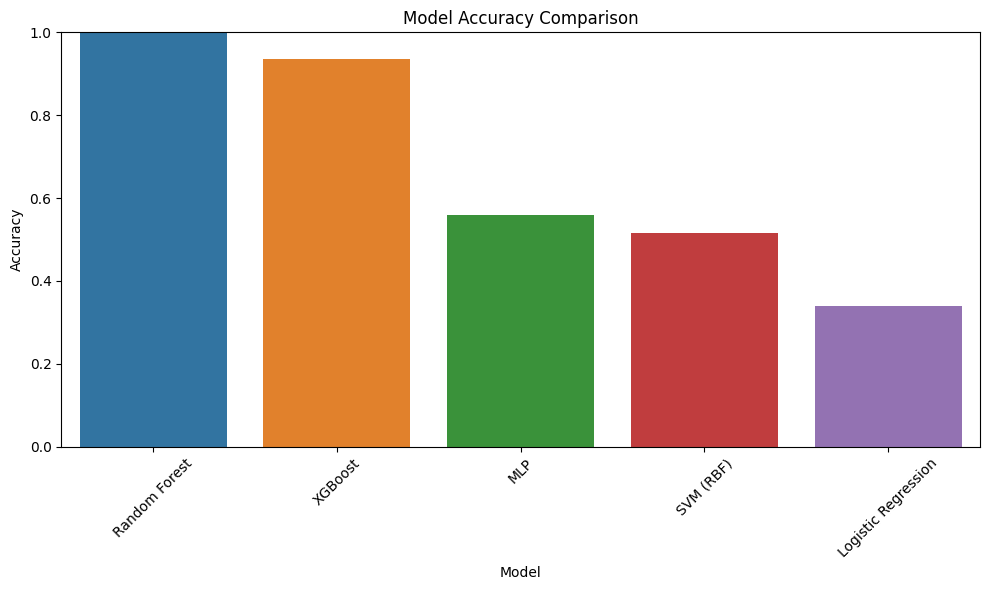

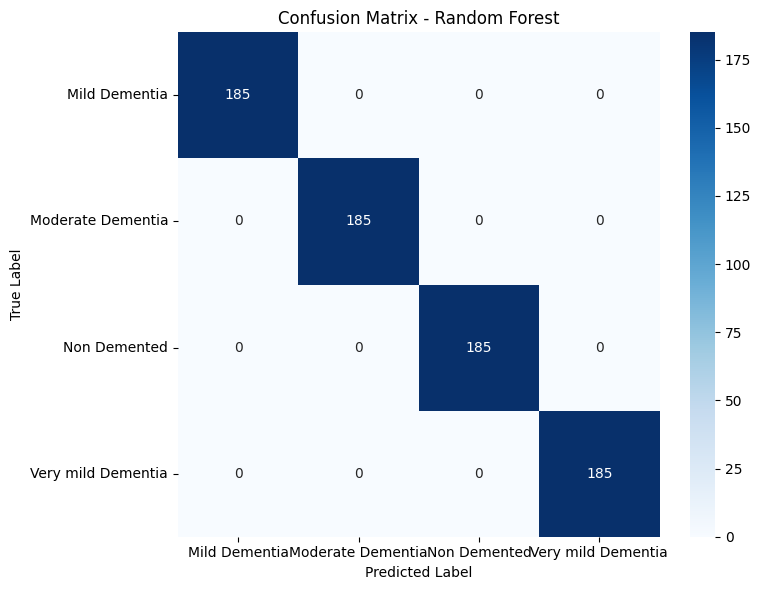


Best model: Random Forest with accuracy 1.0000

Detailed classification report for the best model:
                    precision    recall  f1-score   support

     Mild Dementia       1.00      1.00      1.00       185
 Moderate Dementia       1.00      1.00      1.00       185
      Non Demented       1.00      1.00      1.00       185
Very mild Dementia       1.00      1.00      1.00       185

          accuracy                           1.00       740
         macro avg       1.00      1.00      1.00       740
      weighted avg       1.00      1.00      1.00       740

Re-training models with best parameters from previous run...
Using 5 PCA components
Trained SVM with best parameters
Trained Random Forest with best parameters
Trained XGBoost with best parameters
Trained Logistic Regression with best parameters
Trained MLP with best parameters
Using 5 PCA components for ensemble
Using sklearn's VotingClassifier for ensemble...
Fitting voting classifier...
Making ensemble predicti

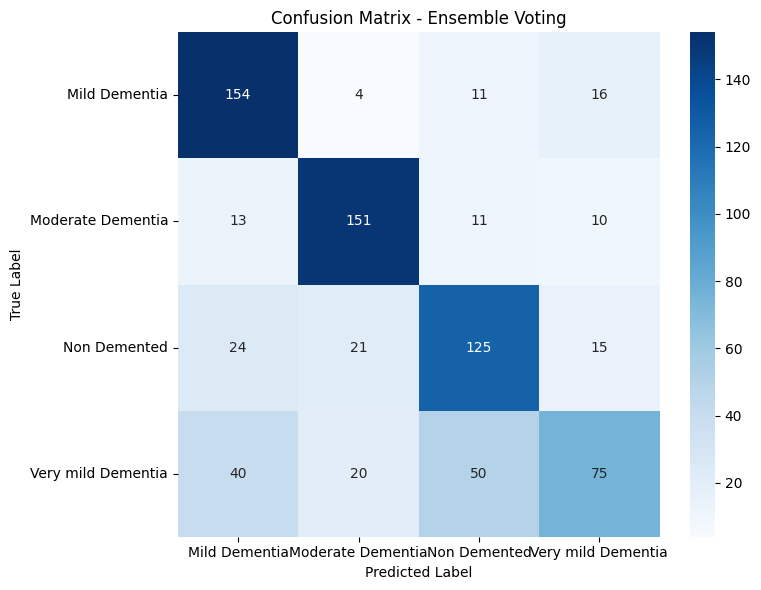

Using 5 PCA components for ensemble weight optimization
Optimizing ensemble weights (this may take some time)...
Model: SVM (RBF), Accuracy: 0.4716, Assigned Weight: 1
Model: Random Forest, Accuracy: 1.0000, Assigned Weight: 3
Model: XGBoost, Accuracy: 0.9351, Assigned Weight: 2
Model: Logistic Regression, Accuracy: 0.3459, Assigned Weight: 1
Model: MLP, Accuracy: 0.4703, Assigned Weight: 1
Heuristic weights score: 0.9919
Uniform weights score: 0.9230
Model: Random Forest, Rank: 1, Assigned Weight: 5
Model: XGBoost, Rank: 2, Assigned Weight: 4
Model: SVM (RBF), Rank: 3, Assigned Weight: 3
Model: MLP, Rank: 4, Assigned Weight: 2
Model: Logistic Regression, Rank: 5, Assigned Weight: 1
Rank-based weights score: 0.9662
Using heuristic weights (based on individual model accuracy)

Optimal weights:
  SVM_(RBF): 1
  Random_Forest: 3
  XGBoost: 2
  Logistic_Regression: 1
  MLP: 1


In [31]:
results_df, best_model = train_and_evaluate_models(feature_df, selected_features, X_pca, y, use_pca=True)

# Extract trained models with best parameters
trained_models = extract_trained_models_from_best_params(
    feature_df, selected_features, X_pca, y, use_pca=True, results_df=results_df)

# Create and evaluate ensemble
ensemble_results, voting_clf = create_and_evaluate_ensemble(
    feature_df, selected_features, X_pca, y, use_pca=True, trained_models=trained_models)

# Optimize ensemble weights
weight_dict, weighted_voting_clf = optimize_ensemble_weights(
    feature_df, selected_features, X_pca, y, use_pca=True, trained_models=trained_models)


In [33]:
def save_trained_models(trained_models, output_dir="./saved_models"):
       
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Dictionary to store paths to saved models
    saved_models_paths = {}
    
    print(f"Saving {len(trained_models)} trained models to {output_dir}...")
    
    # Save each model
    for model_name, model in trained_models.items():
        # Clean model name for use in filename
        clean_name = model_name.replace(' ', '_').replace('(', '').replace(')', '').lower()
        
        # Create filename with timestamp
        filename = f"{clean_name}.pkl"
        filepath = os.path.join(output_dir, filename)
        
        try:
            # Try to save with joblib first (more efficient for large NumPy arrays)
            joblib.dump(model, filepath)
            saved_models_paths[model_name] = filepath
            print(f"Successfully saved {model_name} to {filepath}")
        except Exception as e:
            print(f"Error saving {model_name} with joblib: {e}")
            
            try:
                # Fall back to pickle if joblib fails
                with open(filepath, 'wb') as f:
                    pickle.dump(model, f)
                saved_models_paths[model_name] = filepath
                print(f"Successfully saved {model_name} to {filepath} using pickle")
            except Exception as e2:
                print(f"Error saving {model_name} with pickle: {e2}")
                warnings.warn(f"Could not save model {model_name}")
    
    # Create a metadata file with information about the models
    metadata_filepath = os.path.join(output_dir, f"model_metadata_.txt")
    
    try:
        with open(metadata_filepath, 'w') as meta_file:
            meta_file.write("Model Export Information\n")
            meta_file.write("======================\n\n")
            meta_file.write(f"Export Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
            meta_file.write(f"Number of Models: {len(trained_models)}\n\n")
            
            meta_file.write("Models Information:\n")
            for model_name, model in trained_models.items():
                meta_file.write(f"\n- Model: {model_name}\n")
                meta_file.write(f"  File: {os.path.basename(saved_models_paths[model_name])}\n")
                meta_file.write(f"  Type: {type(model).__name__}\n")
                
                # Try to get hyperparameters if available
                try:
                    params = model.get_params()
                    meta_file.write("  Parameters:\n")
                    for param, value in params.items():
                        meta_file.write(f"    - {param}: {value}\n")
                except:
                    meta_file.write("  Parameters: Not available\n")
        
        print(f"\nCreated metadata file at: {metadata_filepath}")
    except Exception as e:
        print(f"Error creating metadata file: {e}")
    
    return saved_models_paths


# Example usage:

# 1. After training your models, save them:
trained_models = extract_trained_models_from_best_params(feature_df, selected_features, X_pca, y)
saved_paths = save_trained_models(trained_models)




Re-training models with best parameters from previous run...
Using 5 PCA components
Trained SVM with best parameters
Trained Random Forest with best parameters
Trained XGBoost with best parameters
Trained Logistic Regression with best parameters
Trained MLP with best parameters
Saving 5 trained models to ./saved_models...
Successfully saved SVM (RBF) to ./saved_models/svm_rbf.pkl
Successfully saved Random Forest to ./saved_models/random_forest.pkl
Successfully saved XGBoost to ./saved_models/xgboost.pkl
Successfully saved Logistic Regression to ./saved_models/logistic_regression.pkl
Successfully saved MLP to ./saved_models/mlp.pkl

Created metadata file at: ./saved_models/model_metadata_.txt
